<a href="https://colab.research.google.com/github/maxstclair/DS4002/blob/main/Pretrained_Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script takes a pre-trained models (Inception v3) and tests it on the Oxford Pets dataset. After testing the model, the script trains and evaluates the Inception v3 model to improve accuracy.

## Loading Packages

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torchvision import transforms, models
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torch.optim.lr_scheduler import StepLR

# Inception v3

## Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Transform

We need photos to be 299x299 pixels for Inception v3.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Load Dataset

In [ ]:
train_dataset = OxfordIIITPet(root="data", split="trainval",
                              target_types="category", transform=transform, download=True)
test_dataset = OxfordIIITPet(root="data", split="test",
                             target_types="category", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 792M/792M [00:39<00:00, 20.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.5MB/s]


## Define Model

In [ ]:
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 37)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 37)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 109MB/s] 


## Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training Loop

In [ ]:
model.train()
for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs, aux_outputs = model(images)
    loss1 = criterion(outputs, labels)
    loss2 = criterion(aux_outputs, labels)
    loss = loss1 + 0.4 * loss2

    loss.backward()
    optimizer.step()

    print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    if batch_idx == 2:  # limit to a few batches for now
        break

Batch 0, Loss: 5.0901
Batch 1, Loss: 5.0571
Batch 2, Loss: 5.2184


## Eval Loop

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        break  # test one batch for now

print(f"Test Accuracy on first batch: {100 * correct / total:.2f}%")

Test Accuracy on first batch: 0.00%


# Improving Model Accuracy (Inception v3 model)

## Setup

In [ ]:
# use GPU if available with fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("checkpoints", exist_ok=True)

## Transform

In [ ]:
# transform training data
train_transform = transforms.Compose([
    transforms.Resize((320, 320)), # resize to slightly larger size
    transforms.RandomResizedCrop(299), # random crop to 299 for Inception v3
    transforms.RandomHorizontalFlip(), # random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# transform validation data
val_transform = transforms.Compose([
    transforms.Resize((299, 299)), # resize to 299x299 for Inception v3
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Datasets

In [ ]:
# load training and validation datasets
train_dataset = OxfordIIITPet(root="data", split="trainval", target_types="category", transform=train_transform, download=True)
val_dataset = OxfordIIITPet(root="data", split="test", target_types="category", transform=val_transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

100%|██████████| 792M/792M [00:27<00:00, 28.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 17.2MB/s]


## Model

In [ ]:
# load pretrained Inception v3 and adjust output layers
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 37) # main output for 37 breeds
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 37) # auxiliary classifier
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 86.0MB/s] 


## Optimizer and Loss

In [ ]:
criterion = nn.CrossEntropyLoss() # standard classification loss
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # reduce LR every 10 epochs

## Train and Evaluate Functions

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)

        # combine main and auxiliary loss
        loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total  # compute accuracy
    return total_loss / len(loader), acc

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    return total_loss / len(loader), acc

## Training Loop

In [ ]:
num_epochs = 5 # small number for running efficiency
best_val_acc = 0.0

for epoch in range(num_epochs):
    # train for one epoch and evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step() # step learning rate

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc # if the validation accuracy is better than prior epochs, save as the best model
        torch.save(model.state_dict(), f"checkpoints/best_inceptionv3.pth")
        print("Saved as the best model.")

Epoch 1/5
Train Loss: 0.7806 | Train Acc: 85.54%
Val   Loss: 0.3634 | Val   Acc: 88.55%
Saved as the best model.
Epoch 2/5
Train Loss: 0.6427 | Train Acc: 88.12%
Val   Loss: 0.3043 | Val   Acc: 90.68%
Saved as the best model.
Epoch 3/5
Train Loss: 0.5469 | Train Acc: 89.76%
Val   Loss: 0.3520 | Val   Acc: 89.48%
Epoch 4/5
Train Loss: 0.5194 | Train Acc: 89.92%
Val   Loss: 0.3132 | Val   Acc: 91.09%
Saved as the best model.
Epoch 5/5
Train Loss: 0.4962 | Train Acc: 89.70%
Val   Loss: 0.3442 | Val   Acc: 89.75%


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

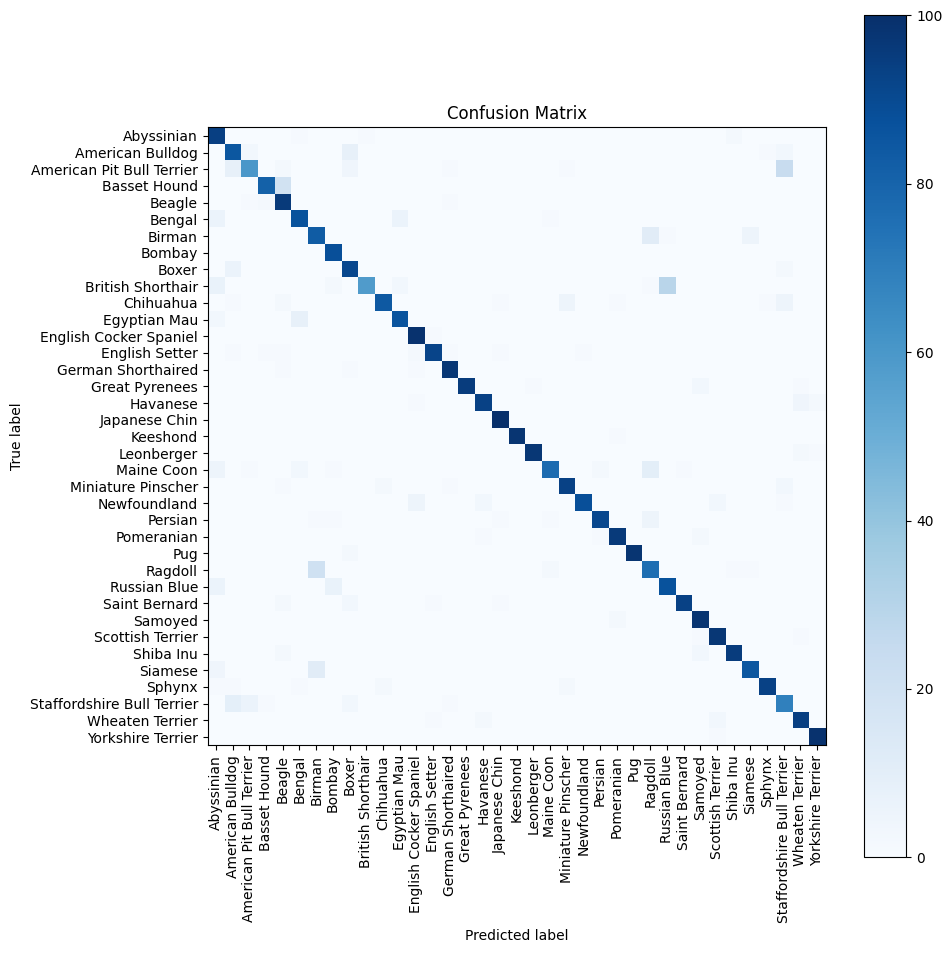

In [ ]:
# set model to evaluation mode
model.eval()

# store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes  # List of breed names

# graph the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=False, cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()